# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

600

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Config Information
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

In [4]:
# Decalre list values 
cities_list = []
lat = []
lon = []
temp = []
humidity = []
clouds = []
wind = []
country = []
date = []
# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="
# Print statement
print('*'*20)
print('Data Processing')
print('*'*20)
# Counter Variable
i = 1
# Loop
for city in cities:
    try: 
        response = requests.get(query_url + city).json()
        # Pull data into list
        cities_list.append(response['name'])
        lat.append(response['coord']['lat'])
        lon.append(response['coord']['lon'])
        temp.append(response['main']['temp_max'])
        humidity.append(response['main']['humidity'])
        clouds.append(response['clouds']['all'])
        wind.append(response['wind']['speed'])
        country.append(response['sys']['country'])
        date.append(response['dt'])
        print(f'Processing record {i} | {city}')
        i +=1
    except KeyError:
        print(f'City {i} not found. Skipping...')
print('*'*20)
print('Done')
print('*'*20)

********************
Data Processing
********************
Processing record 1 | saint-georges
City 2 not found. Skipping...
Processing record 2 | mar del plata
Processing record 3 | makakilo city
Processing record 4 | lebu
City 5 not found. Skipping...
Processing record 5 | rikitea
Processing record 6 | mumford
Processing record 7 | ushuaia
Processing record 8 | castro
Processing record 9 | barrow
City 10 not found. Skipping...
Processing record 10 | vaini
Processing record 11 | khatanga
Processing record 12 | qaanaaq
Processing record 13 | cherskiy
Processing record 14 | vilhena
Processing record 15 | praia da vitoria
Processing record 16 | hermanus
Processing record 17 | yellowknife
Processing record 18 | hualmay
Processing record 19 | jerantut
Processing record 20 | guamuchil
Processing record 21 | saint-philippe
Processing record 22 | kloulklubed
City 23 not found. Skipping...
Processing record 23 | vao
Processing record 24 | cape town
Processing record 25 | lazaro cardenas
Process

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
# Create Data Dictonary
weather_data = {
    'City': cities_list,
    'Latitude': lat,
    'Longitude': lon,
    'Max Temperature': temp, 
    'Humidity': humidity,
    'Cloudiness': clouds,
    'Wind Speed': wind,
    'Country': country,
    'Date': pd.to_datetime(date, unit="s")
}
weather_df = pd.DataFrame(weather_data)
# Exporting the data to a CSV file.
weather_df.to_csv(output_data_file)
# View head to check data
weather_df.head()

,City,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed,Country,Date
0,St. George's,12.0564,-61.7485,82.08,83,20,5.75,GD,2021-09-24 01:52:10
1,Mar del Plata,-38.0023,-57.5575,50.02,93,0,4.61,AR,2021-09-24 01:52:10
2,Makakilo City,21.3469,-158.0858,80.92,73,90,8.05,US,2021-09-24 01:52:11
3,Lebu,-37.6167,-73.6500,50.34,86,0,11.70,CL,2021-09-24 01:52:11
4,Rikitea,-23.1203,-134.9692,74.12,78,100,23.24,PF,2021-09-24 01:52:12


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [6]:
#  Get the indices of cities that have humidity over 100%.
print(weather_df[weather_df['Humidity']>100].index.values)
weather_df.describe()

[]


,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed
count,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000
mean,18.737198,21.375912,65.083729,72.945155,58.261426,7.783382
std,32.793588,90.931478,15.800654,19.292730,38.328817,5.716394
min,-54.800000,-175.200000,11.930000,8.000000,0.000000,0.000000
25%,-8.145700,-59.831250,54.580000,64.500000,20.000000,3.440000
50%,21.500000,25.970400,66.790000,78.000000,75.000000,6.290000
75%,45.184250,102.580950,79.225000,87.000000,97.000000,11.040000
max,78.218600,178.416700,91.900000,100.000000,100.000000,34.850000


In [7]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

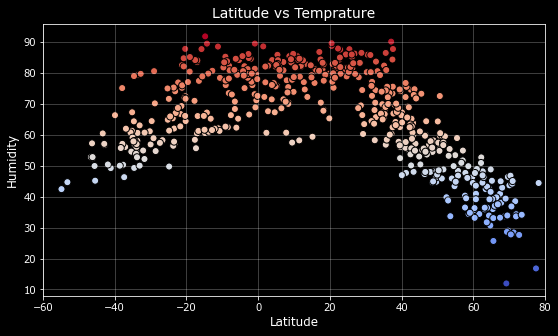

In [8]:
# Set up vars
lat = weather_df['Latitude']
temp = weather_df['Max Temperature']
# Figure size
plt.figure(figsize=(9,5))
# Plot 
plt.scatter(lat, temp, cmap='coolwarm', c = temp, edgecolor= 'black', marker='o', s=50)
# Label Plot
plt.title('Latitude vs Temprature', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Temprature', fontsize=12)
plt.ylabel('Humidity', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()

## Latitude vs. Humidity Plot

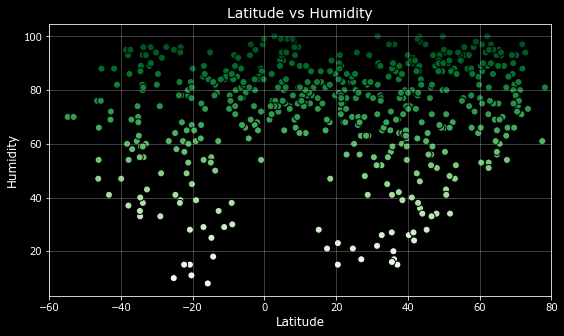

In [9]:
# Set up vars
lat = weather_df['Latitude']
humidity = weather_df['Humidity']
# Figure size
plt.figure(figsize=(9,5))
# Plot
plt.scatter(lat, humidity, c=humidity, cmap='Greens', edgecolor='black', s=50)
# Label
plt.title('Latitude vs Humidity', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Humidity', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()


## Latitude vs. Cloudiness Plot

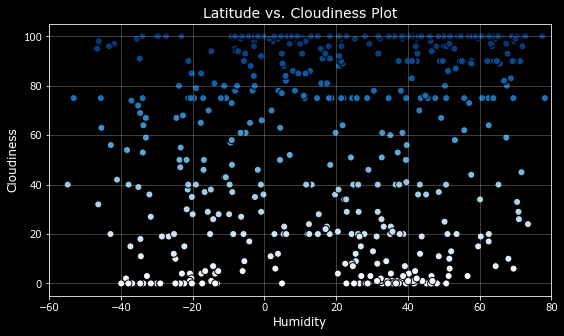

In [10]:
# Set up vars
lat = weather_df['Latitude']
cloud = weather_df['Cloudiness']
# Figure size
plt.figure(figsize=(9,5))
# Plot
plt.scatter(lat, cloud, c=cloud, edgecolors='black', cmap='Blues', s =50)
# Label
plt.title('Latitude vs. Cloudiness Plot', fontsize=14)
plt.xlabel('Humidity', fontsize=12)
plt.ylabel('Cloudiness', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()

## Latitude vs. Wind Speed Plot

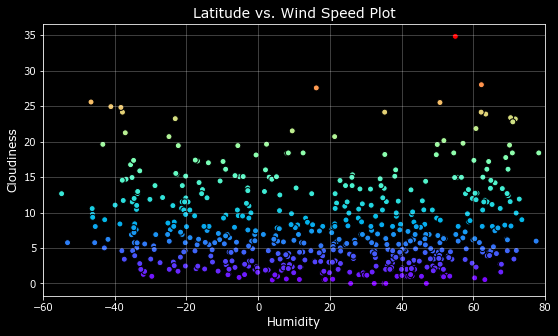

In [11]:
# Set up vars
lat = weather_df['Latitude']
wind = weather_df['Wind Speed']
# Figure size 
plt.figure(figsize=(9,5))
# Plot 
plt.scatter(lat, wind, c=wind, cmap='rainbow', edgecolors='black')
# Label
plt.title('Latitude vs. Wind Speed Plot', fontsize=14)
plt.xlabel('Humidity', fontsize=12)
plt.ylabel('Cloudiness', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()

## Linear Regression

In [12]:
# Create the dataframe for hemispheres
north_df = weather_df[weather_df['Latitude'] > 0]
south_df = weather_df[weather_df['Latitude'] < 0]
# Create a function for linregress 
def linreg(x_values, y_values, title, text_coords):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    # Regress calcs
    regress_vals = x_values * slope + intercept
    line_eq = 'y =' + str(round(slope, 2)) + 'x +' + str(round(intercept , 2))
    # Plot
    plt.scatter(x_values, y_values, edgecolor='black', marker='o')
    plt.plot(x_values, regress_vals, 'r-')
    # Annotate line eq
    plt.annotate(line_eq, text_coords, fontsize=15)
    # Labels
    plt.xlabel('Latitude', fontsize=12)
    plt.ylabel(title, fontsize=12)
    print(f"The r-value is: {rvalue**2}")
    plt.show()


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.72617234221904


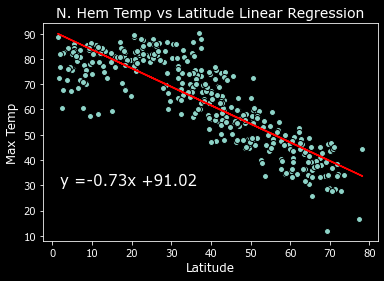

In [13]:
x_values = north_df['Latitude']
y_values = north_df['Max Temperature']
plt.title('N. Hem Temp vs Latitude Linear Regression', fontsize=14)
linreg(x_values, y_values, 'Max Temp', (2, 30))

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.4819196146161095


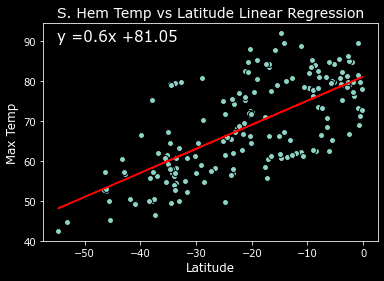

In [14]:
x_values = south_df['Latitude']
y_values = south_df['Max Temperature']
plt.title('S. Hem Temp vs Latitude Linear Regression', fontsize=14)
linreg(x_values, y_values, 'Max Temp', (-55, 90))

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 9.20543078145239e-05


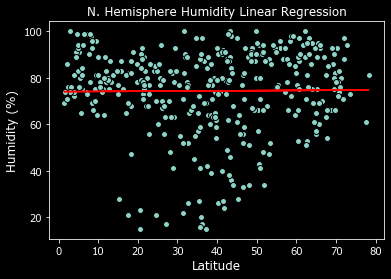

In [15]:
x_values = north_df['Latitude']
y_values = north_df['Humidity']
plt.title("N. Hemisphere Humidity Linear Regression")
linreg(x_values, y_values, 'Humidity (%)', (45,10))

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 9.20543078145239e-05


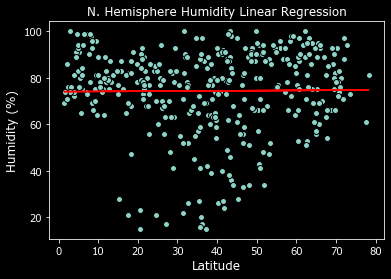

In [16]:
x_values = north_df['Latitude']
y_values = north_df['Humidity']
plt.title("N. Hemisphere Humidity Linear Regression")
linreg(x_values, y_values, 'Humidity (%)', (45,10))

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.014634808945999476


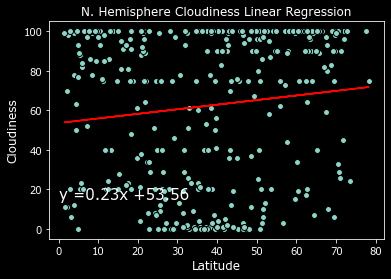

In [17]:

x_values = north_df['Latitude']
y_values = north_df['Cloudiness']
plt.title("N. Hemisphere Cloudiness Linear Regression")
linreg(x_values, y_values, 'Cloudiness', (0,15))

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.06382866591508247


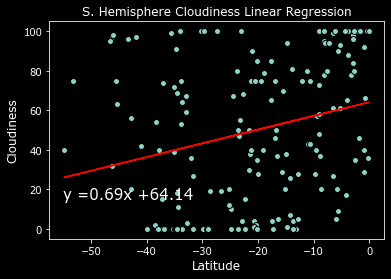

In [18]:
x_values = south_df['Latitude']
y_values = south_df['Cloudiness']
plt.title("S. Hemisphere Cloudiness Linear Regression")
linreg(x_values, y_values, 'Cloudiness', (-55,15))

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.037399414209666006


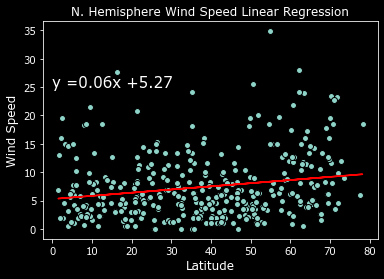

In [19]:
x_values = north_df['Latitude']
y_values = north_df['Wind Speed']
plt.title("N. Hemisphere Wind Speed Linear Regression")
linreg(x_values, y_values, 'Wind Speed', (0,25))

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.05990784596332618


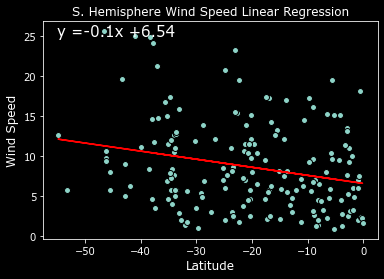

In [20]:
x_values = south_df['Latitude']
y_values = south_df['Wind Speed']
plt.title("S. Hemisphere Wind Speed Linear Regression")
linreg(x_values, y_values, 'Wind Speed', (-55,25))